In [18]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

#!gdown --id "19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF" --output covid.train.csv
#!gdown --id "1CE240jLm2npU-tdz81-oVKEF3T2yfT1O" --output covid.test.csv

In [19]:
#PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [20]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [21]:
import pandas as pd
import numpy as np

data = pd.read_csv(r'/Users/stevenyu/Workspace/MachineLearning/HW1/covid.train.csv')

X = data[data.columns[1:94]]
y = data[data.columns[94]]


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn import preprocessing

#標準化
X = (X - X.min()) / (X.max() - X.min())

#sklearn SelectKBeest 選 feature
bestfeature = SelectKBest(score_func=r_regression,k=5)
fit = bestfeature.fit(X,y)

#製作 feature score best 25 表格
score = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(X.columns)
FeatureScore = pd.concat([columns,score],axis=1)
FeatureScore.columns = ['FeatureName','Score']
FeatureScore.nlargest(25,'Score')

,FeatureName,Score
75,tested_positive.1,0.991012
57,tested_positive,0.981165
42,hh_cmnty_cli,0.879724
60,hh_cmnty_cli.1,0.879438
78,hh_cmnty_cli.2,0.878218
43,nohh_cmnty_cli,0.869938
61,nohh_cmnty_cli.1,0.869278
79,nohh_cmnty_cli.2,0.867535
40,cli,0.838504
58,cli.1,0.838224


In [22]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77]

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & dev sets
            if mode == 'train':
                #indices = [i for i in range(len(data)) if i % 10 != 0]
                indices = [i for i in range(len(data))]
            elif mode == 'dev':
                #indices = [i for i in range(len(data)) if i % 10 == 0]
                indices = [i for i in range(len(data))]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [23]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [24]:

class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),#使用BN，加速訓練
            nn.Dropout(p=0.2),#使用Dropout，減少過擬和
            nn.LeakyReLU(),#變更激活函數
            nn.Linear(32, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        regularization_loss = 0
        for param in model.parameters():
        # TODO: you may implement L1/L2 regularization here
        # 使用L2 regularization
            regularization_loss += torch.sum(abs(param))
            regularization_loss += torch.sum(param ** 2)
        return self.criterion(pred, target) + 1e-5 * regularization_loss
        #return self.criterion(pred, target)

1. Batch Normalization:
    - 作法：
        Batch Normalization 的作法就是對每一個 mini-batch 都進行正規化到平均值為0、標準差為1的常態分佈。
    - 改善：
        1. 減緩梯度消失
        2. 解決 Internal Covariate Shift 的問題 
        3. 加速收斂
    - 參考：https://medium.com/ching-i/batch-normalization-介紹-135a24928f12

----

2. Activation Function:
    - 定義：
        神經元透過 activation function 進行非線性轉換，獲取充分的特徵組合，有助於下層神經元的學習。
    - 種類：
        1. Sigmoid：
            - 常用於二分類
            - 輸出範圍限於0~1之間，且為連續變數，便於求導
            - 對輸入有微小改變時，變得較不敏感，梯度趨近於0，權重不會更新，容易出現梯度消失的狀況
        2. ReLU：
            - 收斂的速度快
            - X>0區間解決了梯度消失的問題
            - X<0的區間，發生dead ReLU的現象，梯度恆為0 (產生原因：參數初始化、learning rate太大。)
        3. Leaky-ReLU：
            - 其優缺點跟ReLU相似，但解決了X<0的區段梯度消失的問題
        4. ELU
    - 參考：https://ithelp.ithome.com.tw/articles/10276865

----

3. Regularization:
    - WHY?
        - 為了解決 overfitting 的問題 (訓練過程中表現很好，但是在測試的結果卻表現很差)
    - 目的：
        讓複雜的模型倒退回簡單的模型，使得整個 function 更加平滑。
    - 種類：
        1. L1：把模型裏頭所有的參數都取絕對值
            - 將沒有用的權重設為0，留下模型認為重要的權重。
            - 有可能導致零權重，因刪除更多特徵而使模型稀疏。
        2. L2：模型裏頭所有的參數都取平方求和
            - 不會只留下某個權重，而是削弱所有權重(但仍保留)，讓所有權重與神經元都處於活動狀態。
            - 會對更大的權重值造成更大的影響，將使權重值保持較小。
    - Tips：
        1. 實務上較常用L2正規化，但在CNN裡面適合的是L1，因為結果較稀疏(sparse)。
        2. 我們在訓練模型的過程會update參數，讓參數離0愈來愈遠，而regularization就是把參數拉回來一點，不要離0太遠。
    



In [25]:

def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [26]:

def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [27]:

def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

- Epoch：所有的 batch 看過一遍，叫做一個 epoch

- Batch：
    - 特性：
        1. Batch Size 大的傾向於走到峽谷
        2. Batch Size 小的傾向於走到盆地
    - 結論：
        1. 使用較小的 Batch Size 在更新參數時會有 Noisy (有利於訓練)
        2. 使用較小的 Batch Size 可以避免 Overfitting (有利於測試)
        3. 使用較大的 Batch Size 完成一個 epoch 時間較短

----

- Momentum：
    - 定義：
        所謂的 momentum 就是 update 的方向不是只考慮現在的 gradient，而是考慮過去所有 gradient 的總合。

----

- Tips：
    - critical points 梯度為 0
    - saddle point 和 local minima 都屬於 critical point
        - 可由 Hessian matrix 區分
        - local minima 比較少遇到
        - 可藉由沿 Hessian 矩陣的特徵向量方向離開 saddle point
    - 較小的 batch size 和 momentum 可幫助離開 critical points

----

- 如何找尋最佳的學習率？
    - 狀況一：loss 不再下降時，未必說明此時到達 critical point ，可能只是在山谷的谷壁間來回走
    - 狀況二：使用固定的學習率(Gradient Descent)，即使是在凸面體的優化，都會讓優化的過程非常困難
        - 較大的學習率：loss 在山谷的谷壁間震蕩而不會下降
        - 較小的學習率：梯度較小時幾乎難以移動

----

- Adaptive Learning Rate
    - 原則：
        1. 平坦 ⇒ learning rate 調大一點
        2. 坡度很大 ⇒ learning rate 可以設得小一點
    - 類型：
        1. Adagrad：考慮之前所有的梯度大小 
        2. RMSProp：添加參數 $\alpha$調整當前梯度與過去梯度的重要性 (添越大說明過去的梯度訊息更重要)
        3. Adam = RMSProp + Momentum（最常用的策略）


In [28]:

device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features
delta = np.random.normal(loc=0,scale=0.000001)

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 5000,                # maximum number of epochs
    'batch_size': 200,               # mini-batch size for dataloader
    'optimizer': 'Adam',             # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.003,                 # learning rate of SGD
        #'momentum': 0.9             # momentum for SGD
    },
    'l1_lambda':1e-5 + delta,
    'early_stop': 500,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}


In [29]:

tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)


Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (2700 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 14)


In [30]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device


In [31]:

model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 243.2556)
Saving model (epoch =    2, loss = 200.7119)
Saving model (epoch =    5, loss = 139.6529)
Saving model (epoch =    6, loss = 89.4655)
Saving model (epoch =    7, loss = 66.8512)
Saving model (epoch =    8, loss = 65.9680)
Saving model (epoch =    9, loss = 48.7085)
Saving model (epoch =   12, loss = 31.2748)
Saving model (epoch =   13, loss = 11.8665)
Saving model (epoch =   21, loss = 10.1367)
Saving model (epoch =   23, loss = 9.1753)
Saving model (epoch =   24, loss = 8.0343)
Saving model (epoch =   28, loss = 7.5946)
Saving model (epoch =   30, loss = 6.7625)
Saving model (epoch =   31, loss = 5.7359)
Saving model (epoch =   33, loss = 5.4797)
Saving model (epoch =   35, loss = 5.2158)
Saving model (epoch =   39, loss = 4.3478)
Saving model (epoch =   41, loss = 4.0322)
Saving model (epoch =   44, loss = 3.4617)
Saving model (epoch =   45, loss = 3.1873)
Saving model (epoch =   47, loss = 2.9536)
Saving model (epoch =   49, loss = 2.9108

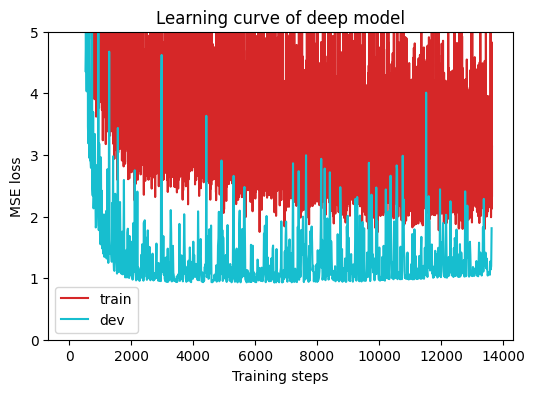

In [32]:
plot_learning_curve(model_loss_record, title='deep model')

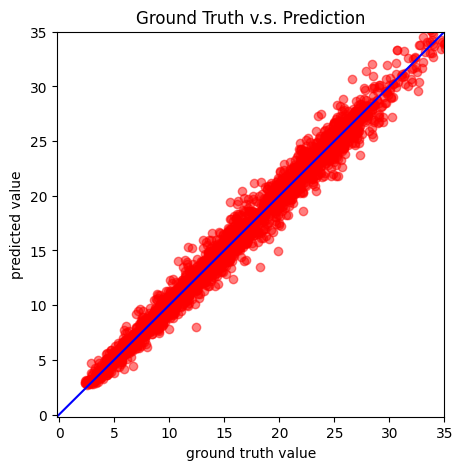

In [33]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [34]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# Score

## Private Score: 0.89803
## Public Score: 0.88165